### Entangling gate on two coupled qubits

#### Imports

In [1]:
# !pip install -q -U pip
# !pip install -q matplotlib

In [2]:
# System imports
import copy
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from typing import List

# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes
import c3.utils.qt_utils as qt_utils
import c3.utils.tf_utils as tf_utils

#### Model components
The model consists of two qubits with 3 levels each and slightly different parameters:

In [3]:
qubit_lvls = 3
freq_q1 = 5e9
anhar_q1 = -210e6
t1_q1 = 27e-6
t2star_q1 = 39e-6
qubit_temp = 50e-3

q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Qty(value=freq_q1, min_val=4.995e9, max_val=5.005e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_q1, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
    t1=Qty(value=t1_q1, min_val=1e-6, max_val=90e-6, unit='s'),
    t2star=Qty(value=t2star_q1, min_val=10e-6, max_val=90e-3, unit='s'),
    temp=Qty(value=qubit_temp, min_val=0.0, max_val=0.12, unit='K')
)

freq_q2 = 5.6e9
anhar_q2 = -240e6
t1_q2 = 23e-6
t2star_q2 = 31e-6
q2 = chip.Qubit(
    name="Q2",
    desc="Qubit 2",
    freq=Qty(value=freq_q2, min_val=5.595e9, max_val=5.605e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_q2, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
    t1=Qty(value=t1_q2, min_val=1e-6, max_val=90e-6,unit='s'),
    t2star=Qty(value=t2star_q2, min_val=10e-6, max_val=90e-6, unit='s'),
    temp=Qty(value=qubit_temp, min_val=0.0, max_val=0.12, unit='K')
)

There is a static coupling in x-direction between them: $(b_1+b_1^\dagger)(b_2+b_2^\dagger)$

In [4]:
coupling_strength = 50e6
q1q2 = chip.Coupling(
    name="Q1-Q2",
    desc="coupling",
    comment="Coupling qubit 1 to qubit 2",
    connected=["Q1", "Q2"],
    strength=Qty(
        value=coupling_strength,
        min_val=-1 * 1e3 ,
        max_val=200e6 ,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.int_XX
)

and each qubit has a drive line

In [5]:
drive1 = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive
)
drive2 = chip.Drive(
    name="d2",
    desc="Drive 2",
    comment="Drive line 2 on qubit 2",
    connected=["Q2"],
    hamiltonian_func=hamiltonians.x_drive
)

All parts are collected in the model. The initial state will be thermal at a non-vanishing temperature.

In [6]:
init_temp = 50e-3
init_ground = tasks.InitialiseGround(
    init_temp=Qty(value=init_temp, min_val=-0.001, max_val=0.22, unit='K')
)

model = Mdl(
    [q1, q2], # Individual, self-contained components
    [drive1, drive2, q1q2],  # Interactions between components
    [init_ground] # SPAM processing
)
model.set_lindbladian(False)
model.set_dressed(True)

#### Control signals
The devices for the control line are set up

In [7]:
sim_res = 100e9 # Resolution for numerical simulation
awg_res = 2e9 # Realistic, limited resolution of an AWG
v2hz = 1e9

lo = devices.LO(name='lo', resolution=sim_res)
awg = devices.AWG(name='awg', resolution=awg_res)
mixer = devices.Mixer(name='mixer')
resp = devices.Response(
    name='resp',
    rise_time=Qty(value=0.3e-9, min_val=0.05e-9, max_val=0.6e-9, unit='s'),
    resolution=sim_res
)
dig_to_an = devices.DigitalToAnalog(name="dac", resolution=sim_res)
v_to_hz = devices.VoltsToHertz(
    name='v_to_hz',
    V_to_Hz=Qty(value=v2hz, min_val=0.9e9, max_val=1.1e9, unit='Hz/V')
)

The generator combines the parts of the signal generation and assignes a signal chain to each control line.

In [8]:
generator = Gnr(
        devices={
            "LO": lo,
            "AWG": awg,
            "DigitalToAnalog": dig_to_an,
            "Response": resp,
            "Mixer": mixer,
            "VoltsToHertz": v_to_hz
        },
        chains={
            "d1": ["LO", "AWG", "DigitalToAnalog", "Response", "Mixer", "VoltsToHertz"],
            "d2": ["LO", "AWG", "DigitalToAnalog", "Response", "Mixer", "VoltsToHertz"]
        }
    )

#### Gates-set and Parameter map
Both qubits will be resonantly driven with a Gaussian envelope.

In [9]:
t_final = 7e-9
sideband = 50e6 
gauss_params_single = {
    'amp': Qty(value=0.5, min_val=0.2, max_val=0.6, unit="V"),
    't_final': Qty(value=t_final, min_val=0.5 * t_final, max_val=1.5 * t_final, unit="s"),
    'sigma': Qty(value=t_final / 4, min_val=t_final / 8, max_val=t_final / 2, unit="s"),
    'xy_angle': Qty(value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit='rad'),
    'freq_offset': Qty(value=-sideband - 3e6, min_val=-56 * 1e6, max_val=-52 * 1e6, unit='Hz 2pi'),
    'delta': Qty(value=-1, min_val=-5, max_val=3, unit="")
}

gauss_env_single_1 = pulse.Envelope(
    name="gauss1",
    desc="Gaussian envelope on drive 1",
    params=gauss_params_single,
    shape=envelopes.gaussian_nonorm
)
gauss_env_single_2 = pulse.Envelope(
    name="gauss2",
    desc="Gaussian envelope on drive 2",
    params=copy.deepcopy(gauss_params_single),
    shape=envelopes.gaussian_nonorm
)

The carrier signal of each drive is set to the resonance frequency
of the corresponding qubit.

In [10]:
lo_freq_q1 = freq_q1 + sideband
carr_1 = pulse.Carrier(
    name="carrier",
    desc="Carrier on drive 1",
    params={
        'freq': Qty(value=lo_freq_q1, min_val=0.9 * lo_freq_q1, max_val=1.1 * lo_freq_q1, unit='Hz 2pi'),
        'framechange': Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit='rad')
    }
)

lo_freq_q2 = freq_q2 + sideband
carr_2 = pulse.Carrier(
    name="carrier",
    desc="Carrier on drive 2",
    params={
        'freq': Qty(value=lo_freq_q2, min_val=0.9 * lo_freq_q2, max_val=1.1 * lo_freq_q2, unit='Hz 2pi'),
        'framechange': Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit='rad')
    }
)

#### Instructions
The instruction to be optimised is a CNOT gates controlled by qubit 1.

In [11]:
# CNOT comtrolled by qubit 1
cnot12 = gates.Instruction(
    name="cnot12", targets=[0, 1], t_start=0.0, t_end=t_final, channels=["d1", "d2"],
    ideal=np.array([
        [1,0,0,0],
        [0,1,0,0],
        [0,0,0,1],
        [0,0,1,0]
    ])
)
cnot12.add_component(gauss_env_single_1, "d1")
cnot12.add_component(carr_1, "d1")
cnot12.add_component(gauss_env_single_2, "d2")
cnot12.add_component(carr_2, "d2")
cnot12.comps["d1"]["carrier"].params["framechange"].set_value(
    (-sideband * t_final) * 2 * np.pi % (2 * np.pi)
)

#### The experiment
All components are collected in the parameter map and the experiment is set up.

In [12]:
parameter_map = PMap(instructions=[cnot12], model=model, generator=generator)
exp = Exp(pmap=parameter_map)

Calculate and print the propagator before the optimisation.

In [13]:
unitaries = exp.compute_propagators()
print(unitaries[cnot12.get_key()])

tf.Tensor(
[[ 2.90040286e-01+0.06796916j -9.05419295e-02-0.44005323j
   3.32932691e-02+0.02624818j  1.83699230e-02-0.4519875j
  -6.87075560e-01+0.11948446j  3.30388750e-02-0.07559797j
   5.12968176e-02+0.03489245j  4.00691980e-02-0.06469375j
   2.56872145e-03+0.01350305j]
 [-1.31456151e-01-0.43111727j  2.26936794e-01-0.20111687j
   1.91084183e-02-0.01480484j -6.51684826e-01+0.24723886j
  -2.47467811e-01-0.3840622j  -3.20181777e-02-0.00415827j
   1.46942329e-02-0.08169747j  4.25011406e-02+0.00106457j
  -4.06200000e-03+0.00186351j]
 [ 3.78678020e-02-0.00179018j  2.76809420e-03-0.02315965j
  -4.13538094e-01-0.33772374j -9.69947972e-03-0.07244919j
  -5.30975369e-02+0.01107233j -2.52346729e-01+0.79596642j
   8.22126812e-03+0.00440004j -3.55403231e-04-0.00818356j
  -3.93164689e-02-0.07564104j]
 [-3.46355245e-01+0.29125939j  5.89368247e-01+0.37203659j
  -6.51961274e-02+0.00734386j -2.31070430e-01-0.182206j
  -2.55521484e-01+0.38035364j -2.33895953e-02-0.05274812j
  -2.81575528e-02+0.02641964j

#### Dynamics

The system is initialised in the state $|0,1\rangle$ so that a transition to $|1,1\rangle$ should be visible.

In [14]:
psi_init = [[0] * 9]
psi_init[0][1] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
print(init_state)

tf.Tensor(
[[0.+0.j]
 [1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]], shape=(9, 1), dtype=complex128)


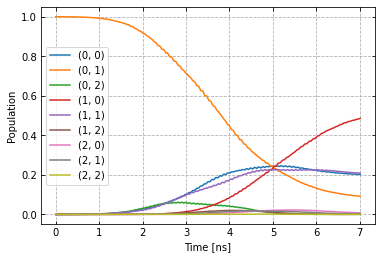

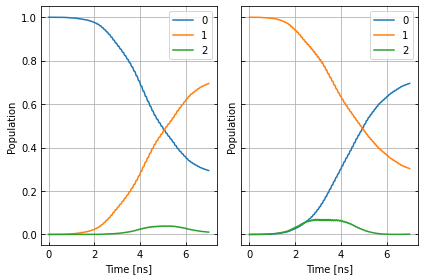

In [15]:
def plot_dynamics(exp, psi_init, seq, goal=-1):
        """
        Plotting code for time-resolved populations.

        Parameters
        ----------
        psi_init: tf.Tensor
            Initial state or density matrix.
        seq: list
            List of operations to apply to the initial state.
        goal: tf.float64
            Value of the goal function, if used.
        debug: boolean
            If true, return a matplotlib figure instead of saving.
        """
        model = exp.pmap.model
        dUs = exp.partial_propagators
        psi_t = psi_init.numpy()
        pop_t = exp.populations(psi_t, model.lindbladian)
        for gate in seq:
            for du in dUs[gate]:
                psi_t = np.matmul(du.numpy(), psi_t)
                pops = exp.populations(psi_t, model.lindbladian)
                pop_t = np.append(pop_t, pops, axis=1)

        fig, axs = plt.subplots(1, 1)
        ts = exp.ts
        dt = ts[1] - ts[0]
        ts = np.linspace(0.0, dt*pop_t.shape[1], pop_t.shape[1])
        axs.plot(ts / 1e-9, pop_t.T)
        axs.grid(linestyle="--")
        axs.tick_params(
            direction="in", left=True, right=True, top=True, bottom=True
        )
        axs.set_xlabel('Time [ns]')
        axs.set_ylabel('Population')
        plt.legend(model.state_labels)
        pass

def getQubitsPopulation(population: np.array, dims: List[int]) -> np.array:
    """
    Splits the population of all levels of a system into the populations of levels per subsystem.
    Parameters
    ----------
    population: np.array
        The time dependent population of each energy level. First dimension: level index, second dimension: time.
    dims: List[int]
        The number of levels for each subsystem.
    Returns
    -------
    np.array
        The time-dependent population of energy levels for each subsystem. First dimension: subsystem index, second
        dimension: level index, third dimension: time.
    """
    numQubits = len(dims)

    # create a list of all levels
    qubit_levels = []
    for dim in dims:
        qubit_levels.append(list(range(dim)))
    combined_levels = list(itertools.product(*qubit_levels))

    # calculate populations
    qubitsPopulations = np.zeros((numQubits, dims[0], population.shape[1]))
    for idx, levels in enumerate(combined_levels):
        for i in range(numQubits):
            qubitsPopulations[i, levels[i]] += population[idx]
    return qubitsPopulations

def plotSplittedPopulation(
    exp: Exp,
    psi_init: tf.Tensor,
    sequence: List[str],
    filename: str = None
) -> None:
    """
    Plots time dependent populations for multiple qubits in separate plots.
    Parameters
    ----------
    exp: Experiment
        The experiment containing the model and propagators
    psi_init: np.array
        Initial state vector
    sequence: List[str]
        List of gate names that will be applied to the state
    -------
    """
    # calculate the time dependent level population
    model = exp.pmap.model
    dUs = exp.partial_propagators
    psi_t = psi_init.numpy()
    pop_t = exp.populations(psi_t, model.lindbladian)
    for gate in sequence:
        for du in dUs[gate]:
            psi_t = np.matmul(du, psi_t)
            pops = exp.populations(psi_t, model.lindbladian)
            pop_t = np.append(pop_t, pops, axis=1)
    dims = [s.hilbert_dim for s in model.subsystems.values()]
    splitted = getQubitsPopulation(pop_t, dims)

    # timestamps
    dt = exp.ts[1] - exp.ts[0]
    ts = np.linspace(0.0, dt * pop_t.shape[1], pop_t.shape[1])

    # create both subplots
    fig, axs = plt.subplots(1, len(splitted), sharey="all")
    for idx, ax in enumerate(axs):
        ax.plot(ts / 1e-9, splitted[idx].T)
        ax.tick_params(direction="in", left=True, right=True, top=False, bottom=True)
        ax.set_xlabel("Time [ns]")
        ax.set_ylabel("Population")
        ax.legend([str(x) for x in np.arange(dims[idx])])
        ax.grid()

    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

sequence = [cnot12.get_key()]
plot_dynamics(exp, init_state, sequence)
#plot_dynamics(exp, init_state, sequence * 10)
plotSplittedPopulation(exp, init_state, sequence, filename="dynamics_before.png")

#### Open-loop optimal control

Now, open-loop optimisation with DRAG enabled is set up.

In [16]:
generator.devices['AWG'].enable_drag_2()

opt_gates = [cnot12.get_key()]
exp.set_opt_gates(opt_gates)

gateset_opt_map=[
    [(cnot12.get_key(), "d1", "gauss1", "amp")],
    [(cnot12.get_key(), "d1", "gauss1", "freq_offset")],
    [(cnot12.get_key(), "d1", "gauss1", "xy_angle")],
    [(cnot12.get_key(), "d1", "gauss1", "delta")],
    [(cnot12.get_key(), "d1", "carrier", "framechange")],
    [(cnot12.get_key(), "d2", "gauss2", "amp")],
    [(cnot12.get_key(), "d2", "gauss2", "freq_offset")],
    [(cnot12.get_key(), "d2", "gauss2", "xy_angle")],
    [(cnot12.get_key(), "d2", "gauss2", "delta")],
    [(cnot12.get_key(), "d2", "carrier", "framechange")]
]
parameter_map.set_opt_map(gateset_opt_map)

parameter_map.print_parameters()

cnot12[0, 1]-d1-gauss1-amp            : 500.000 mV 
cnot12[0, 1]-d1-gauss1-freq_offset    : -53.000 MHz 2pi 
cnot12[0, 1]-d1-gauss1-xy_angle       : -444.089 arad 
cnot12[0, 1]-d1-gauss1-delta          : -1.000  
cnot12[0, 1]-d1-carrier-framechange   : 4.084 rad 
cnot12[0, 1]-d2-gauss2-amp            : 500.000 mV 
cnot12[0, 1]-d2-gauss2-freq_offset    : -53.000 MHz 2pi 
cnot12[0, 1]-d2-gauss2-xy_angle       : -444.089 arad 
cnot12[0, 1]-d2-gauss2-delta          : -1.000  
cnot12[0, 1]-d2-carrier-framechange   : 0.000 rad 



As a fidelity function we choose average fidelity as well as LBFG-S (a wrapper of the scipy implementation) from our library.

In [17]:
import os
import tempfile
from c3.optimizers.optimalcontrol import OptimalControl

log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")
# increase maxfevals to 500+ for better results
opt = OptimalControl(
    dir_path=log_dir,
    fid_func=fidelities.average_infid_set,
    fid_subspace=["Q1", "Q2"],
    pmap=parameter_map,
    algorithm=algorithms.cmaes,
    options={
        "popsize": 15,
        "maxfevals": 100
    },
    run_name="cnot12"
)

Start the optimisation

In [18]:
exp.set_opt_gates(opt_gates)
opt.set_exp(exp)
opt.optimize_controls()

C3:STATUS:Saving as: /tmp/tmpskwo3xlm/c3logs/cnot12/2021_12_06_T_22_24_59/open_loop.log
(7_w,15)-aCMA-ES (mu_w=4.5,w_1=34%) in dimension 10 (seed=964937, Mon Dec  6 22:24:59 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 7.326344256215179e-01 1.0e+00 8.85e-02  8e-02  9e-02 0:13.8
    2     30 7.367559004446577e-01 1.2e+00 8.75e-02  8e-02  1e-01 0:27.4
    3     45 7.139157246650509e-01 1.3e+00 9.55e-02  9e-02  1e-01 0:40.8
    4     60 6.952586691625754e-01 1.5e+00 1.04e-01  9e-02  1e-01 0:54.5
    5     75 6.691554889600820e-01 1.8e+00 1.13e-01  1e-01  2e-01 1:08.0
    6     90 6.642503941891256e-01 1.9e+00 1.22e-01  1e-01  2e-01 1:21.7
    7    105 6.754441193654891e-01 1.9e+00 1.22e-01  1e-01  2e-01 1:35.7
termination on maxfevals=100
final/bestever f-value = 6.754441e-01 6.642504e-01
incumbent solution: [ 0.29354993  0.43400975 -0.62646119  0.04613593 -0.31716057  0.26852775
  0.54834962 -0.64817835 ...]
std deviations: [0.12406951 0.1191

The final parameters and the fidelity are

In [19]:
parameter_map.print_parameters()
print(opt.current_best_goal)

cnot12[0, 1]-d1-gauss1-amp            : 461.437 mV 
cnot12[0, 1]-d1-gauss1-freq_offset    : -52.704 MHz 2pi 
cnot12[0, 1]-d1-gauss1-xy_angle       : 355.730 mrad 
cnot12[0, 1]-d1-gauss1-delta          : -1.058  
cnot12[0, 1]-d1-carrier-framechange   : 827.654 mrad 
cnot12[0, 1]-d2-gauss2-amp            : 428.475 mV 
cnot12[0, 1]-d2-gauss2-freq_offset    : -53.037 MHz 2pi 
cnot12[0, 1]-d2-gauss2-xy_angle       : 73.836 mrad 
cnot12[0, 1]-d2-gauss2-delta          : -484.207 m 
cnot12[0, 1]-d2-carrier-framechange   : 120.479 mrad 

0.6642503941891256


#### Results of the optimisation
Plotting the dynamics with the same initial state:

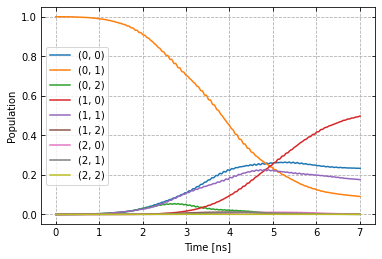

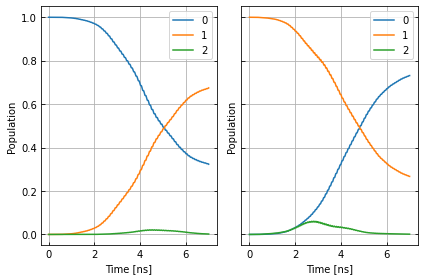

In [20]:
plot_dynamics(exp, init_state, sequence)
plotSplittedPopulation(exp, init_state, sequence, filename="dynamics_after.png")